In [14]:
import pandas as pd
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamulticore import LdaMulticore
from collections import Counter
from operator import itemgetter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from top2vec import Top2Vec

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN

import pickle
import os

from gensim.test.utils import datapath

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dxlee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load process_csv_stage_1.csv

In [2]:
df = pd.read_csv('process_csv_stage_1.csv')
df.columns = ['old_index','preprocessed_text']
df

old_index                                  preprocessed_text
0              1  good morning name appreciate could help put st...
1              2  upgraded card tell agent upgrade anniversary d...
2             10  chase card report however fraudulent applicati...
3             11  try book ticket come across offer apply toward...
4             14  grand son give check deposit chase account fun...
...          ...                                                ...
21067      78303  chase card customer well decade offer multiple...
21068      78309  wednesday call chas visa credit card provider ...
21069      78310  familiar pay understand great risk provide con...
21070      78311  flawless credit chase credit card chase freedo...
21071      78312  roughly year ago close account morgan chase ba...

[21072 rows x 2 columns]

In [3]:
texts = df['preprocessed_text']

tfidf_vectorizer = TfidfVectorizer(
    min_df=10,
    max_df=0.85
)

tfidf = tfidf_vectorizer.fit_transform(texts)

tfidf

<21072x5260 sparse matrix of type '<class 'numpy.float64'>'
	with 1350569 stored elements in Compressed Sparse Row format>

# Load complaint_what_happened from json

In [4]:
# load raw complaint json into raw df 
raw = pd.json_normalize(json.load(open("complaints-2021-05-14_08_16_.json")))

# renaming column
raw.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'complaint_what_happened', 'sub_issue','consumer_consent_provided']

# drop unnecessary columns
raw.drop(['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'sub_issue','consumer_consent_provided'],axis=1,inplace=True)

# drop null values
raw['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True, inplace=True)
raw.dropna(inplace=True)

# clear masked values
def remove_mask(text):
    masked_text_pattern = r"\b[x|X]{2,20}"
    return re.sub(masked_text_pattern,'',text)

removed_mask = raw.complaint_what_happened.apply(remove_mask)

# Topic Modelling

In [5]:
## Initialise corpus, dictionary and topic numbers for NMF and LDA
texts = df['preprocessed_text'].str.split(' ')

dictionary = Dictionary(texts)

dictionary.filter_extremes(
    no_below=2,
    no_above=0.85,
    keep_n=None
)

corpus = [dictionary.doc2bow(text) for text in texts]

topic_nums = list(np.arange(5, 60 + 1, 5))

## Non-Negative Matrix Factorisation

k = 5; Coherence Score = 0.39702
k = 10; Coherence Score = 0.39376
k = 15; Coherence Score = 0.40935
k = 20; Coherence Score = 0.40691
k = 25; Coherence Score = 0.40382
k = 30; Coherence Score = 0.39283
k = 35; Coherence Score = 0.3857
k = 40; Coherence Score = 0.39011
k = 45; Coherence Score = 0.38846
k = 50; Coherence Score = 0.3801
k = 55; Coherence Score = 0.38439
k = 60; Coherence Score = 0.38023


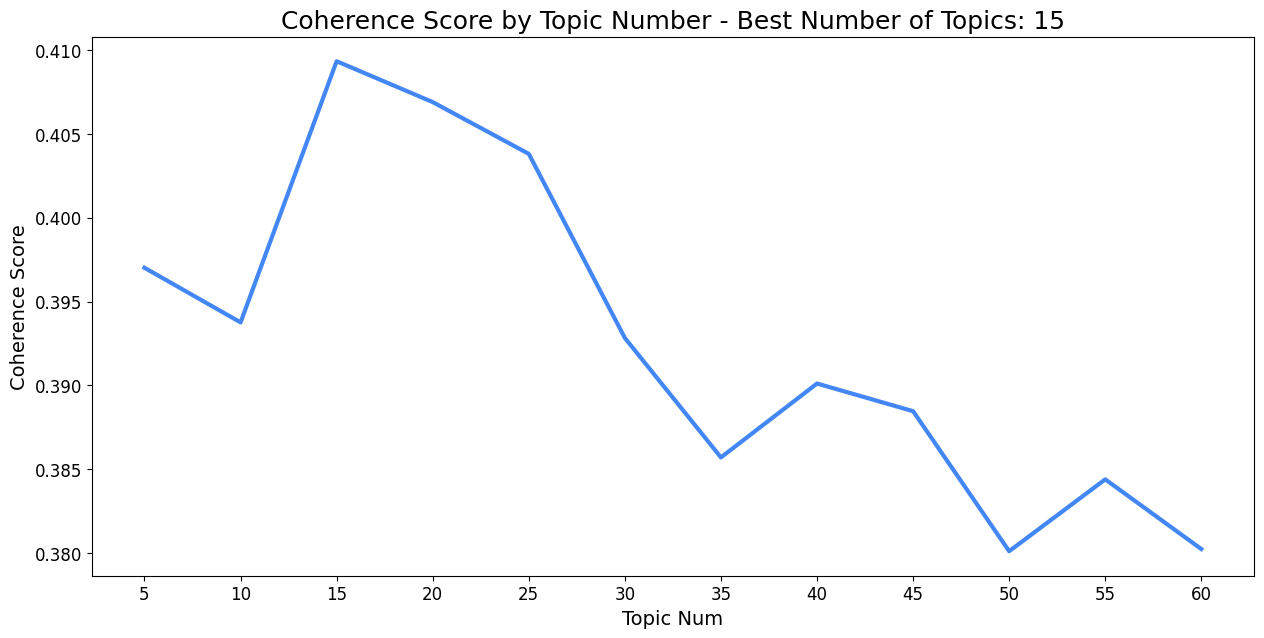

In [6]:
# Coherence Score Evaluation Score is available in the package gensim, 
# thus find the best number of topics using gensim NMF models
nmf_coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=4000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    nmf_coherence_scores.append(round(cm.get_coherence(), 5))
    print(f'k = {num}; Coherence Score = {round(cm.get_coherence(), 5)}')

scores = list(zip(topic_nums, nmf_coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    nmf_coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [7]:
final_nmf = Nmf(
    corpus=corpus,
    num_topics=best_num_topics, 
    id2word=dictionary,
    chunksize=4000,
    passes=5,
    kappa=.1,
    minimum_probability=0.01,
    w_max_iter=300,
    w_stop_condition=0.0001,
    h_max_iter=100,
    h_stop_condition=0.001,
    eval_every=10,
    normalize=True,
    random_state=42
    )
final_nmf.print_topics()

[(0,
  '0.148*"payment" + 0.049*"bank" + 0.035*"mortgage" + 0.032*"make" + 0.031*"pay" + 0.021*"late" + 0.020*"month" + 0.016*"loan" + 0.015*"due" + 0.015*"year"'),
 (1,
  '0.044*"charge" + 0.030*"dispute" + 0.022*"receive" + 0.017*"letter" + 0.015*"fee" + 0.015*"state" + 0.014*"date" + 0.014*"provide" + 0.012*"merchant" + 0.012*"refund"'),
 (2,
  '0.043*"call" + 0.043*"would" + 0.042*"get" + 0.037*"say" + 0.026*"tell" + 0.019*"back" + 0.018*"could" + 0.017*"time" + 0.017*"pay" + 0.016*"ask"'),
 (3,
  '0.052*"loan" + 0.021*"mortgage" + 0.015*"home" + 0.014*"modification" + 0.013*"property" + 0.012*"document" + 0.009*"borrower" + 0.008*"sale" + 0.008*"rate" + 0.008*"foreclosure"'),
 (4,
  '0.190*"check" + 0.043*"deposit" + 0.030*"day" + 0.025*"fund" + 0.018*"cash" + 0.016*"money" + 0.013*"amount" + 0.012*"pay" + 0.010*"clear" + 0.010*"hold"'),
 (5,
  '0.066*"account" + 0.053*"bank" + 0.041*"fraud" + 0.035*"money" + 0.035*"charge" + 0.019*"use" + 0.017*"customer" + 0.016*"fund" + 0.015*"

In [8]:
nmf_topics = []
for index, topic in final_nmf.show_topics(formatted=False, num_topics=best_num_topics, num_words= 10):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))
    nmf_topics.append([w[0] for w in topic])

Topic: 0 
Words: ['payment', 'bank', 'mortgage', 'make', 'pay', 'late', 'month', 'loan', 'due', 'year']
Topic: 1 
Words: ['charge', 'dispute', 'receive', 'letter', 'fee', 'state', 'date', 'provide', 'merchant', 'refund']
Topic: 2 
Words: ['call', 'would', 'get', 'say', 'tell', 'back', 'could', 'time', 'pay', 'ask']
Topic: 3 
Words: ['loan', 'mortgage', 'home', 'modification', 'property', 'document', 'borrower', 'sale', 'rate', 'foreclosure']
Topic: 4 
Words: ['check', 'deposit', 'day', 'fund', 'cash', 'money', 'amount', 'pay', 'clear', 'hold']
Topic: 5 
Words: ['account', 'bank', 'fraud', 'money', 'charge', 'use', 'customer', 'fund', 'transfer', 'deposit']
Topic: 6 
Words: ['report', 'consumer', 'act', 'information', 'request', 'reporting', 'agency', 'fair', 'collection', 'debt']
Topic: 7 
Words: ['account', 'credit', 'report', 'close', 'open', 'issue', 'check', 'letter', 'reason', 'name']
Topic: 8 
Words: ['card', 'service', 'use', 'fraud', 'charge', 'point', 'receive', 'purchase', 'c

In [9]:
# sklearn NMF

nmf_model = NMF(n_components=best_num_topics, random_state=42)
nmf_model.fit(tfidf)
len(tfidf_vectorizer.get_feature_names_out())

5260

In [10]:
H = nmf_model.components_

In [11]:
#Print the Top15 words for each of the topics
words = np.array(tfidf_vectorizer.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((best_num_topics, 15)), index=[f'Topic {i + 1}' for i in range(best_num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(best_num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

Word 1        Word 2      Word 3        Word 4       Word 5  \
Topic 1       account         close        open        reason       saving   
Topic 2          card        credit       apply           use        score   
Topic 3      mortgage          home    property  modification  foreclosure   
Topic 4        charge       dispute  fraudulent      merchant         card   
Topic 5       payment          late        make           due          pay   
Topic 6        report        credit      remove        bureau         debt   
Topic 7         check       deposit        fund          cash         hold   
Topic 8          loan  modification        rate     refinance          car   
Topic 9   transaction         claim       fraud           atm        debit   
Topic 10      inquiry          hard      credit     authorize       remove   
Topic 11         call           say        tell         would          get   
Topic 12      balance      interest         pay          rate         full   
Topic 13          fee     overdraft      annual        refund         late   
Topic 14         bank         money    transfer          wire         fund   
Topic 15      dispute        letter     receive       provide      request   

                Word 6       Word 7       Word 8       Word 9       Word 10  \
Topic 1         access       branch     business      without           new   
Topic 2          limit        offer       amazon  application         point   
Topic 3           year         sale        house       escrow           tax   
Topic 4          fraud      company       amount         make     authorize   
Topic 5          month         auto      monthly    statement           day   
Topic 6      reporting         late  information        theft      identity   
Topic 7            day       branch        clear      account     available   
Topic 8        student  application         auto         home      document   
Topic 9     fraudulent         make          use       police  unauthorized   
Topic 10  unauthorized        apply          add    initiated        report   
Topic 11          back          ask        could        phone        number   
Topic 12     statement     transfer       amount        month           due   
Topic 13        charge        waive  transaction          pay  insufficient   
Topic 14          send         help         take         back        morgan   
Topic 15      merchant         send  information       refund         state   

                Word 11       Word 12       Word 13     Word 14      Word 15  
Topic 1            name        online      personal      closed  information  
Topic 2          reward         close      purchase        year        never  
Topic 3           short          sell           pay   insurance   bankruptcy  
Topic 4        purchase       reverse  unauthorized        bill         visa  
Topic 5            time          bill          date      amount    automatic  
Topic 6          agency          file          show     company        score  
Topic 7          direct           atm       release     cashier        write  
Topic 8           apply        lender       finance        year      process  
Topic 9            card          file    withdrawal  department         deny  
Topic 10  authorization  verification   application        pull  permissible  
Topic 11            day         speak          time        give      receive  
Topic 12            apr      purchase       minimum         owe         bill  
Topic 13           year          time      customer       cover       dollar  
Topic 14            get        refuse        dollar        give    complaint  
Topic 15          email       contact      response     service     document

In [25]:
# filename_nmf = 'final_nmf.sav'

# pickle.dump(final_nmf, open(os.path.join(os.getcwd(),'topic_models',filename_nmf), 'wb'))

filename_nmf = os.path.join(os.getcwd(),'topic_models',"final_nmf")
final_nmf.save(filename_nmf)

## Latent Dirichlet Allocation

k = 5; Coherence Score = 0.38885
k = 10; Coherence Score = 0.39764
k = 15; Coherence Score = 0.41251
k = 20; Coherence Score = 0.41086
k = 25; Coherence Score = 0.4111
k = 30; Coherence Score = 0.39737
k = 35; Coherence Score = 0.4135
k = 40; Coherence Score = 0.39944
k = 45; Coherence Score = 0.39841
k = 50; Coherence Score = 0.40741
k = 55; Coherence Score = 0.40215
k = 60; Coherence Score = 0.39058


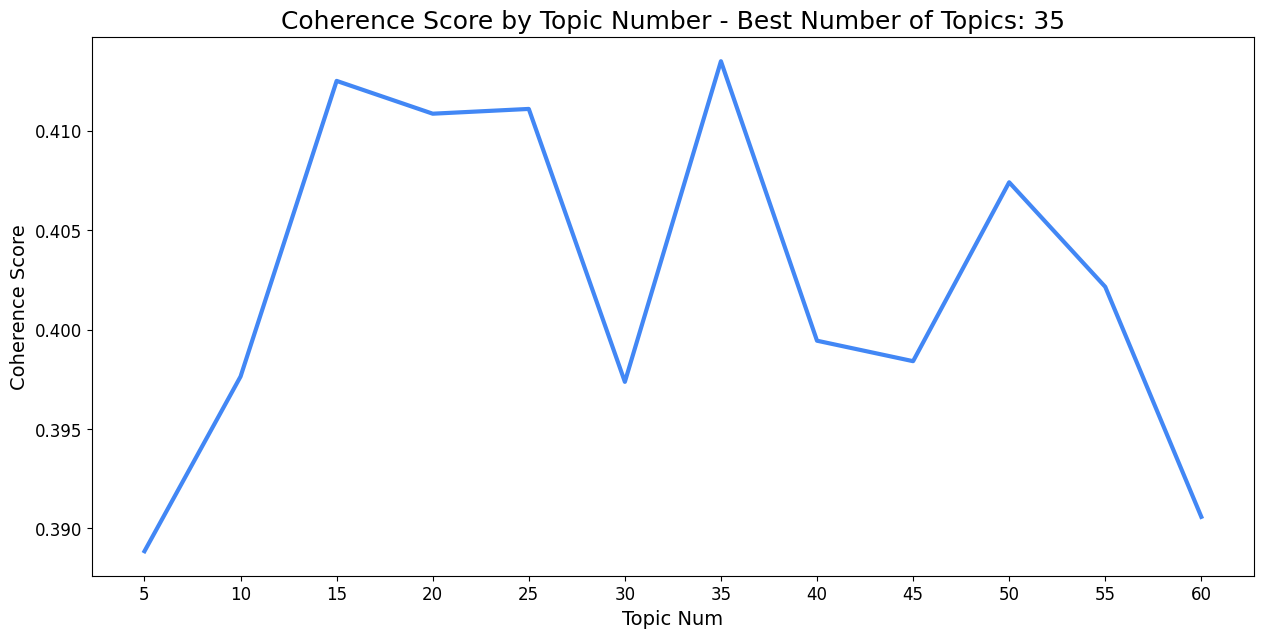

In [16]:
lda_coherence_scores = []

for num in topic_nums:
    lda = LdaMulticore(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        workers=7,
        passes=20, #
        chunksize=2000, #
        iterations=100,
        minimum_probability=0.01,
        alpha='symmetric',
        eta= 'auto',
        per_word_topics=True,
        eval_every=10,
        random_state=42
    )
    cm = CoherenceModel(
        model=lda,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    lda_coherence_scores.append(round(cm.get_coherence(), 5))
    print(f'k = {num}; Coherence Score = {round(cm.get_coherence(), 5)}')

scores = list(zip(topic_nums, lda_coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    lda_coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [17]:
lda_coherence_scores = []

# use number of topic 15/35
# this time we tune passes and chunksize
for pass_num in range(5,26,5): # [5,10,15,20,25]
    for chunk in range(1000,5001,1000):
        lda = LdaMulticore(
            corpus=corpus,
            num_topics=35,
            id2word=dictionary,
            workers=7,
            passes=pass_num, #
            chunksize=chunk, #
            iterations=100,
            minimum_probability=0.01,
            alpha='symmetric',
            eta= 'auto',
            per_word_topics=True,
            eval_every=10,
            random_state=42
        )
        cm = CoherenceModel(
            model=lda,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )

        lda_coherence_scores.append(round(cm.get_coherence(), 5))
        print(f'passes = {pass_num}; chunksize = {chunk}; Coherence Score = {round(cm.get_coherence(), 5)}')

passes = 5; chunksize = 1000; Coherence Score = 0.37188
passes = 5; chunksize = 2000; Coherence Score = 0.36246
passes = 5; chunksize = 3000; Coherence Score = 0.35894
passes = 5; chunksize = 4000; Coherence Score = 0.36221
passes = 5; chunksize = 5000; Coherence Score = 0.36173
passes = 10; chunksize = 1000; Coherence Score = 0.39878
passes = 10; chunksize = 2000; Coherence Score = 0.38595
passes = 10; chunksize = 3000; Coherence Score = 0.37812
passes = 10; chunksize = 4000; Coherence Score = 0.37687
passes = 10; chunksize = 5000; Coherence Score = 0.37513
passes = 15; chunksize = 1000; Coherence Score = 0.40878
passes = 15; chunksize = 2000; Coherence Score = 0.40325
passes = 15; chunksize = 3000; Coherence Score = 0.38728
passes = 15; chunksize = 4000; Coherence Score = 0.39065
passes = 15; chunksize = 5000; Coherence Score = 0.38311
passes = 20; chunksize = 1000; Coherence Score = 0.4163
passes = 20; chunksize = 2000; Coherence Score = 0.41315
passes = 20; chunksize = 3000; Cohere

In [18]:
final_lda = LdaMulticore(
    corpus=corpus,
    num_topics=35,
    id2word=dictionary,
    workers=7,
    passes=25, #
    chunksize=1000, #
    iterations=100,
    minimum_probability=0.01,
    alpha='symmetric',
    eta= 'auto',
    per_word_topics=True,
    eval_every=10,
    random_state=42
)
final_lda.print_topics()

[(10,
  '0.037*"mortgage" + 0.034*"loan" + 0.026*"home" + 0.023*"modification" + 0.017*"payment" + 0.016*"year" + 0.014*"sale" + 0.012*"house" + 0.012*"foreclosure" + 0.012*"time"'),
 (11,
  '0.085*"claim" + 0.052*"transaction" + 0.026*"account" + 0.025*"bank" + 0.024*"money" + 0.021*"file" + 0.021*"fraud" + 0.018*"report" + 0.017*"police" + 0.014*"back"'),
 (23,
  '0.101*"fee" + 0.049*"account" + 0.047*"charge" + 0.024*"bank" + 0.024*"overdraft" + 0.023*"fund" + 0.022*"transaction" + 0.018*"day" + 0.013*"time" + 0.012*"check"'),
 (4,
  '0.130*"transfer" + 0.078*"account" + 0.021*"complaint" + 0.019*"customer" + 0.018*"service" + 0.014*"department" + 0.013*"request" + 0.012*"executive" + 0.011*"number" + 0.011*"provide"'),
 (15,
  '0.070*"car" + 0.034*"vehicle" + 0.027*"lease" + 0.023*"auto" + 0.019*"finance" + 0.019*"pay" + 0.018*"insurance" + 0.016*"title" + 0.013*"rental" + 0.013*"damage"'),
 (20,
  '0.040*"scam" + 0.029*"company" + 0.024*"bank" + 0.016*"people" + 0.016*"work" + 0.0

In [19]:
lda_topics = []
for index, topic in final_lda.show_topics(formatted=False, num_topics=best_num_topics, num_words= 10):
    print('Topic: {} \nWords: {}'.format(index, [w[0] for w in topic]))
    lda_topics.append([w[0] for w in topic])

Topic: 0 
Words: ['number', 'call', 'phone', 'mail', 'name', 'ask', 'say', 'information', 'address', 'card']
Topic: 1 
Words: ['receive', 'letter', 'call', 'send', 'would', 'state', 'request', 'day', 'time', 'contact']
Topic: 2 
Words: ['item', 'order', 'return', 'purchase', 'receive', 'deliver', 'provide', 'package', 'amazon', 'ship']
Topic: 3 
Words: ['travel', 'benefit', 'card', 'ovid', 'trip', 'holder', 'pandemic', 'claim', 'due', 'use']
Topic: 4 
Words: ['transfer', 'account', 'complaint', 'customer', 'service', 'department', 'request', 'executive', 'number', 'provide']
Topic: 5 
Words: ['fraud', 'signature', 'daughter', 'case', 'document', 'police', 'ing', 'name', 'use', 'sign']
Topic: 6 
Words: ['account', 'close', 'open', 'bank', 'reason', 'check', 'card', 'without', 'credit', 'letter']
Topic: 7 
Words: ['interest', 'balance', 'pay', 'payment', 'charge', 'statement', 'rate', 'fee', 'card', 'month']
Topic: 8 
Words: ['refund', 'cancel', 'ticket', 'charge', 'flight', 'credit', 'c

In [20]:
print('\nPerplexity: ', final_lda.log_perplexity(corpus))  

coherence_model_lda = CoherenceModel(model=final_lda, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.682098088874027

Coherence Score:  0.4214710869449688


In [21]:
coherence_per_topic = coherence_model_lda.get_coherence_per_topic()
coherence_per_topic 

[0.39677766049278873,
 0.3870046119023358,
 0.5437161123532641,
 0.3956871354766415,
 0.32310176971374943,
 0.3374813571203896,
 0.3411890677961455,
 0.5008104556269843,
 0.4768680362059176,
 0.4196914171198659,
 0.5366533868650651,
 0.43910079229023025,
 0.27846489024829435,
 0.4148409332343988,
 0.4387087207594341,
 0.48927701763386067,
 0.3244084545175662,
 0.37140030418820225,
 0.4227210235538683,
 0.49191287692811264,
 0.36145293692265723,
 0.44363009402689524,
 0.39162055124435846,
 0.44556598541208015,
 0.4451569455862524,
 0.3983831661219624,
 0.4856046756631193,
 0.4909719853539638,
 0.4841042205497092,
 0.3402976525703525,
 0.5628668502725186,
 0.4467273526936588,
 0.36966517496656903,
 0.45744970561214143,
 0.29817472205055606]

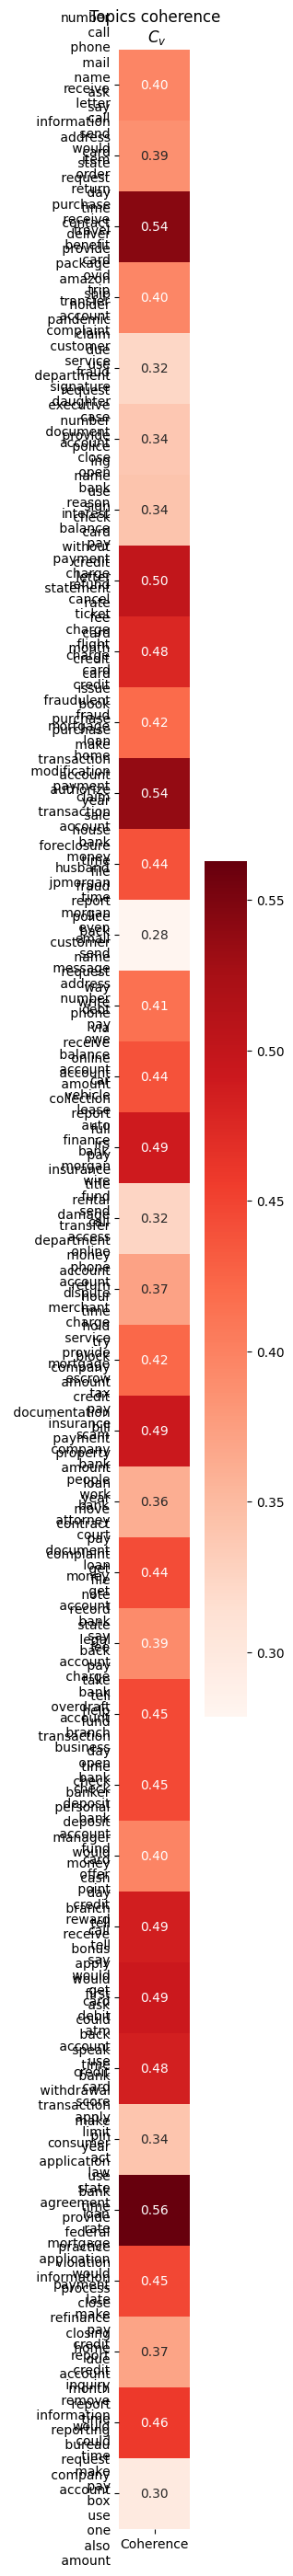

In [22]:
# coherence_per_topic = coherence_model_lda.get_coherence_per_topic()
topics_str = [ '\n '.join(t) for t in lda_topics ]
data_topic_score = pd.DataFrame( data=zip(topics_str, coherence_per_topic), columns=['Topic', 'Coherence'] )
data_topic_score = data_topic_score.set_index('Topic')

fig, ax = plt.subplots( figsize=(4, 35) )
ax.set_title("Topics coherence\n $C_v$")
sns.heatmap(data=data_topic_score, annot=True, square=True,
            cmap='Reds', fmt='.2f',
            linecolor='black', ax=ax )
plt.yticks( rotation=0 )
ax.set_xlabel('')
ax.set_ylabel('')
fig.show()

In [24]:
# filename_lda = 'final_lda.sav'
# pickle.dump(final_lda, open(os.path.join(os.getcwd(),'topic_models',filename_lda), 'wb'))

filename_lda = os.path.join(os.getcwd(),'topic_models',"final_lda")
final_lda.save(filename_lda)

## Top2Vec

In [26]:
umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42}
hdbscan_args = {'min_cluster_size': 10,
                'min_samples':5,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'}

top2vec = Top2Vec(
    documents= list(removed_mask), 
    speed='deep-learn', 
    workers=8, 
    min_count = 0, 
    embedding_model='universal-sentence-encoder', 
    umap_args = umap_args, 
    hdbscan_args = hdbscan_args)

top2vec.get_num_topics()

2024-06-29 00:28:32,463 - top2vec - INFO - Pre-processing documents for training
2024-06-29 00:28:59,203 - top2vec - INFO - Downloading universal-sentence-encoder model
2024-06-29 00:34:05,331 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-06-29 00:35:32,105 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2024-06-29 00:36:39,078 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2024-06-29 00:36:50,761 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


7

In [27]:
top2vec.topic_words

array([['chexsystems', 'cfpb', 'autopay', 'bofa', 'lifelock', 'usaa',
        'citibank', 'repoed', 'chase', 'wamu', 'overdrawn', 'kyc',
        'wellsfargo', 'transunion', 'garnishment', 'preapproval', 'pnc',
        'experian', 'chargebacks', 'echeck', 'churning', 'defaulted',
        'citi', 'overdrafted', 'garnishments', 'overdrafts',
        'chargeback', 'overdraft', 'garnished', 'refinanced', 'bank',
        'defrauded', 'fdic', 'creditor', 'creditors', 'heloc', 'banking',
        'reposession', 'refi', 'insolvent', 'equifax', 'creditcard',
        'debtors', 'amex', 'receivables', 'santander', 'overdraw',
        'fraudsters', 'lender', 'hsbc'],
       ['experian', 'dispute', 'lifelock', 'transunion', 'garnishment',
        'creditor', 'chexsystems', 'equifax', 'defrauded', 'repoed',
        'receivables', 'disputes', 'garnished', 'creditors', 'disputing',
        'litigation', 'garnishing', 'collections', 'fraudulent',
        'bureaus', 'autopay', 'forclosure', 'debtor', 'bai

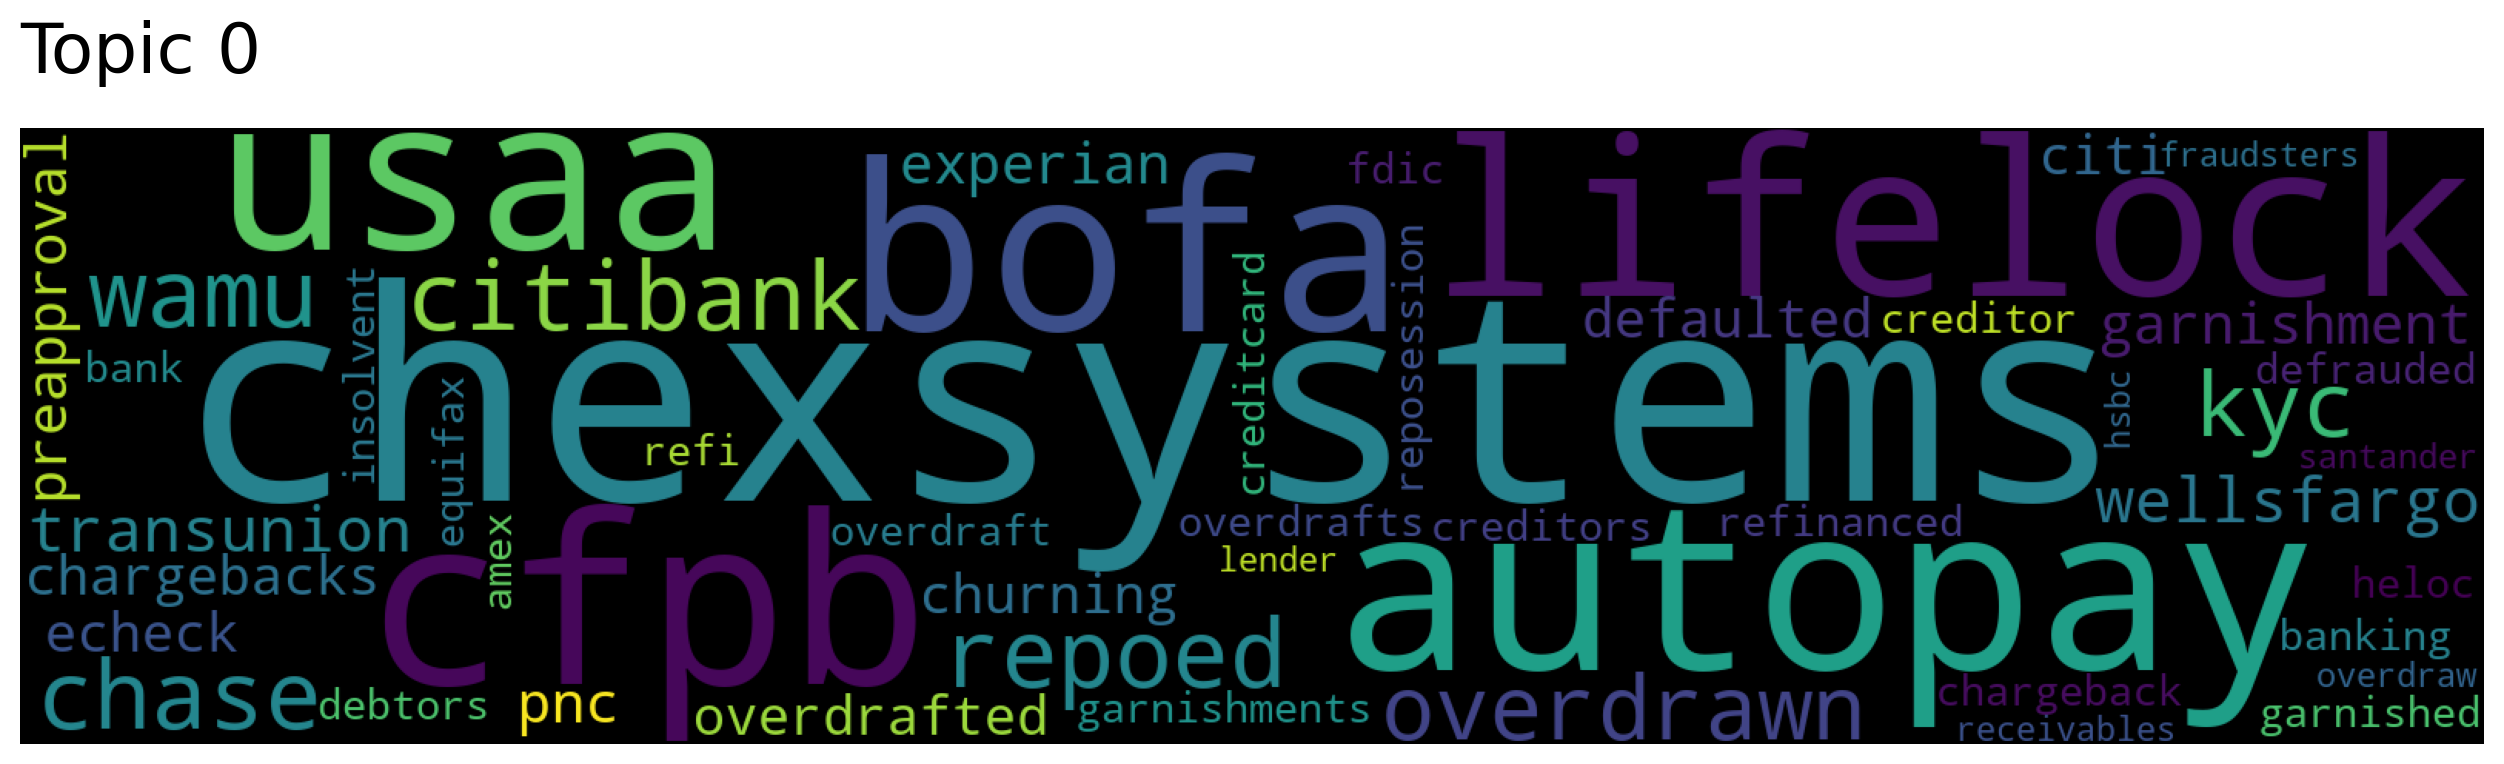

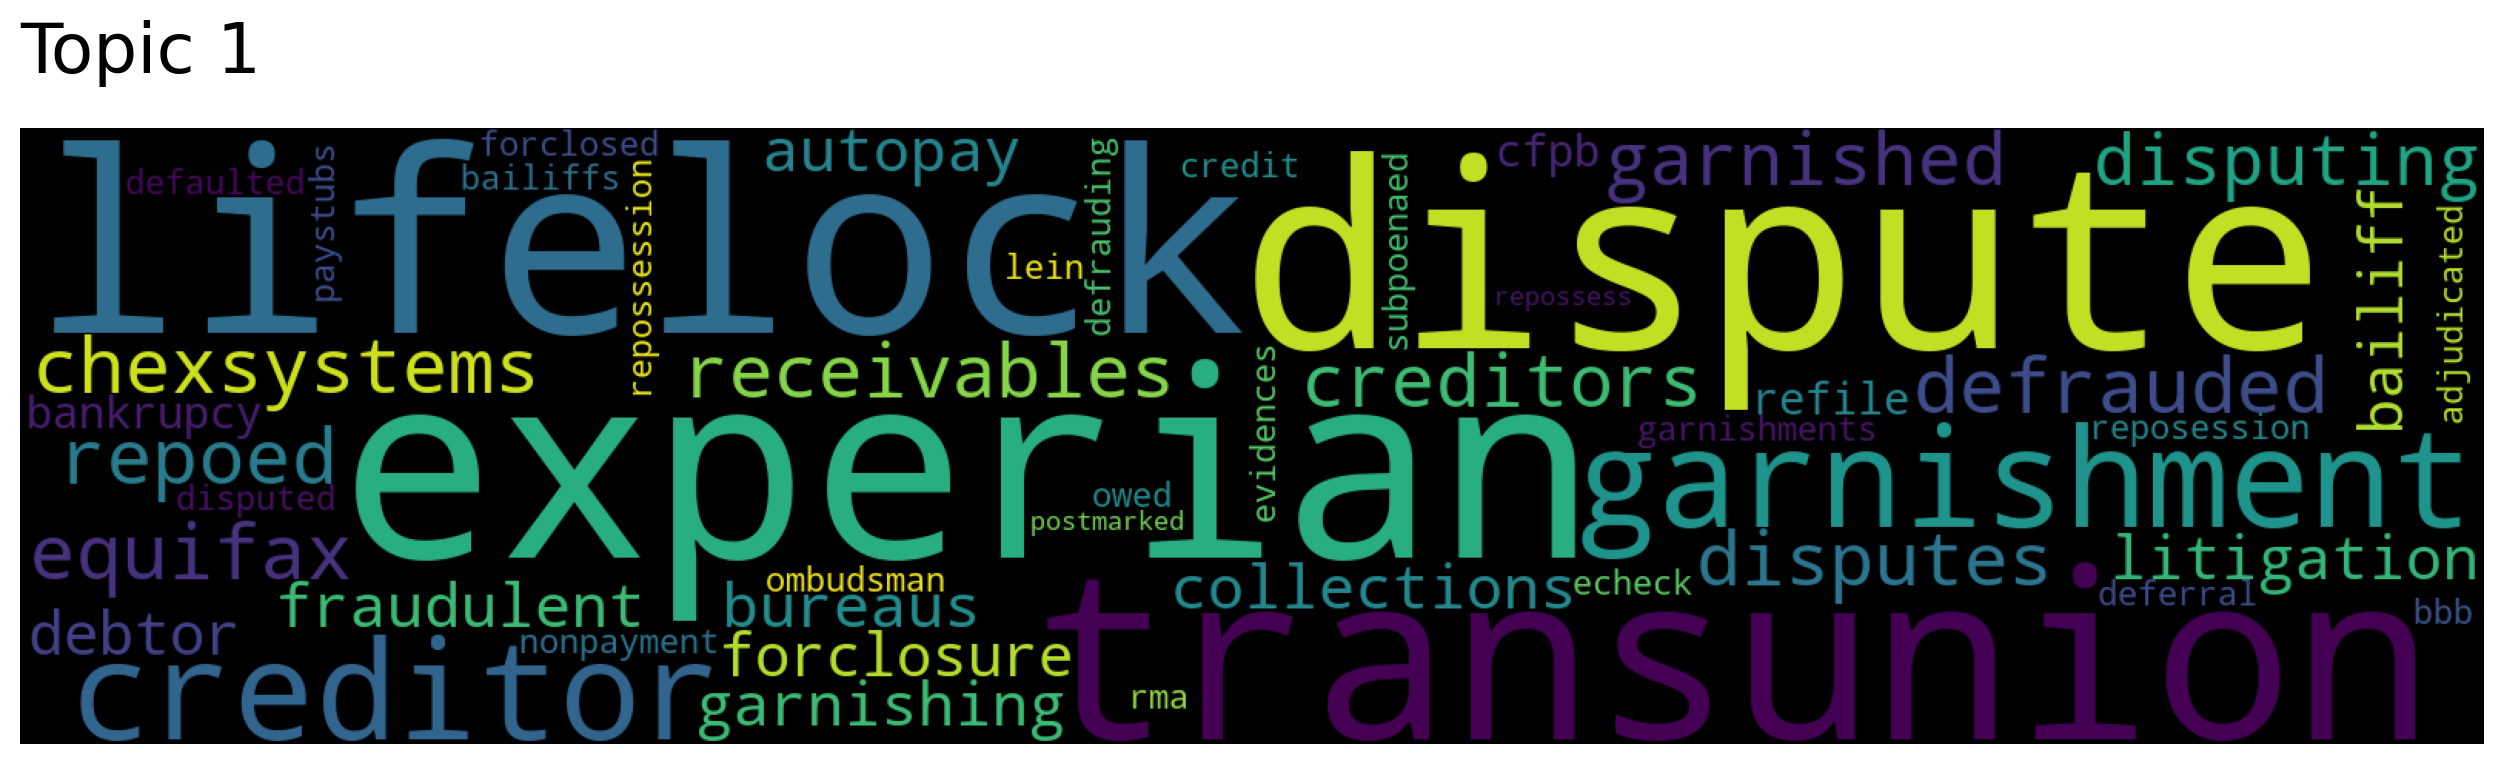

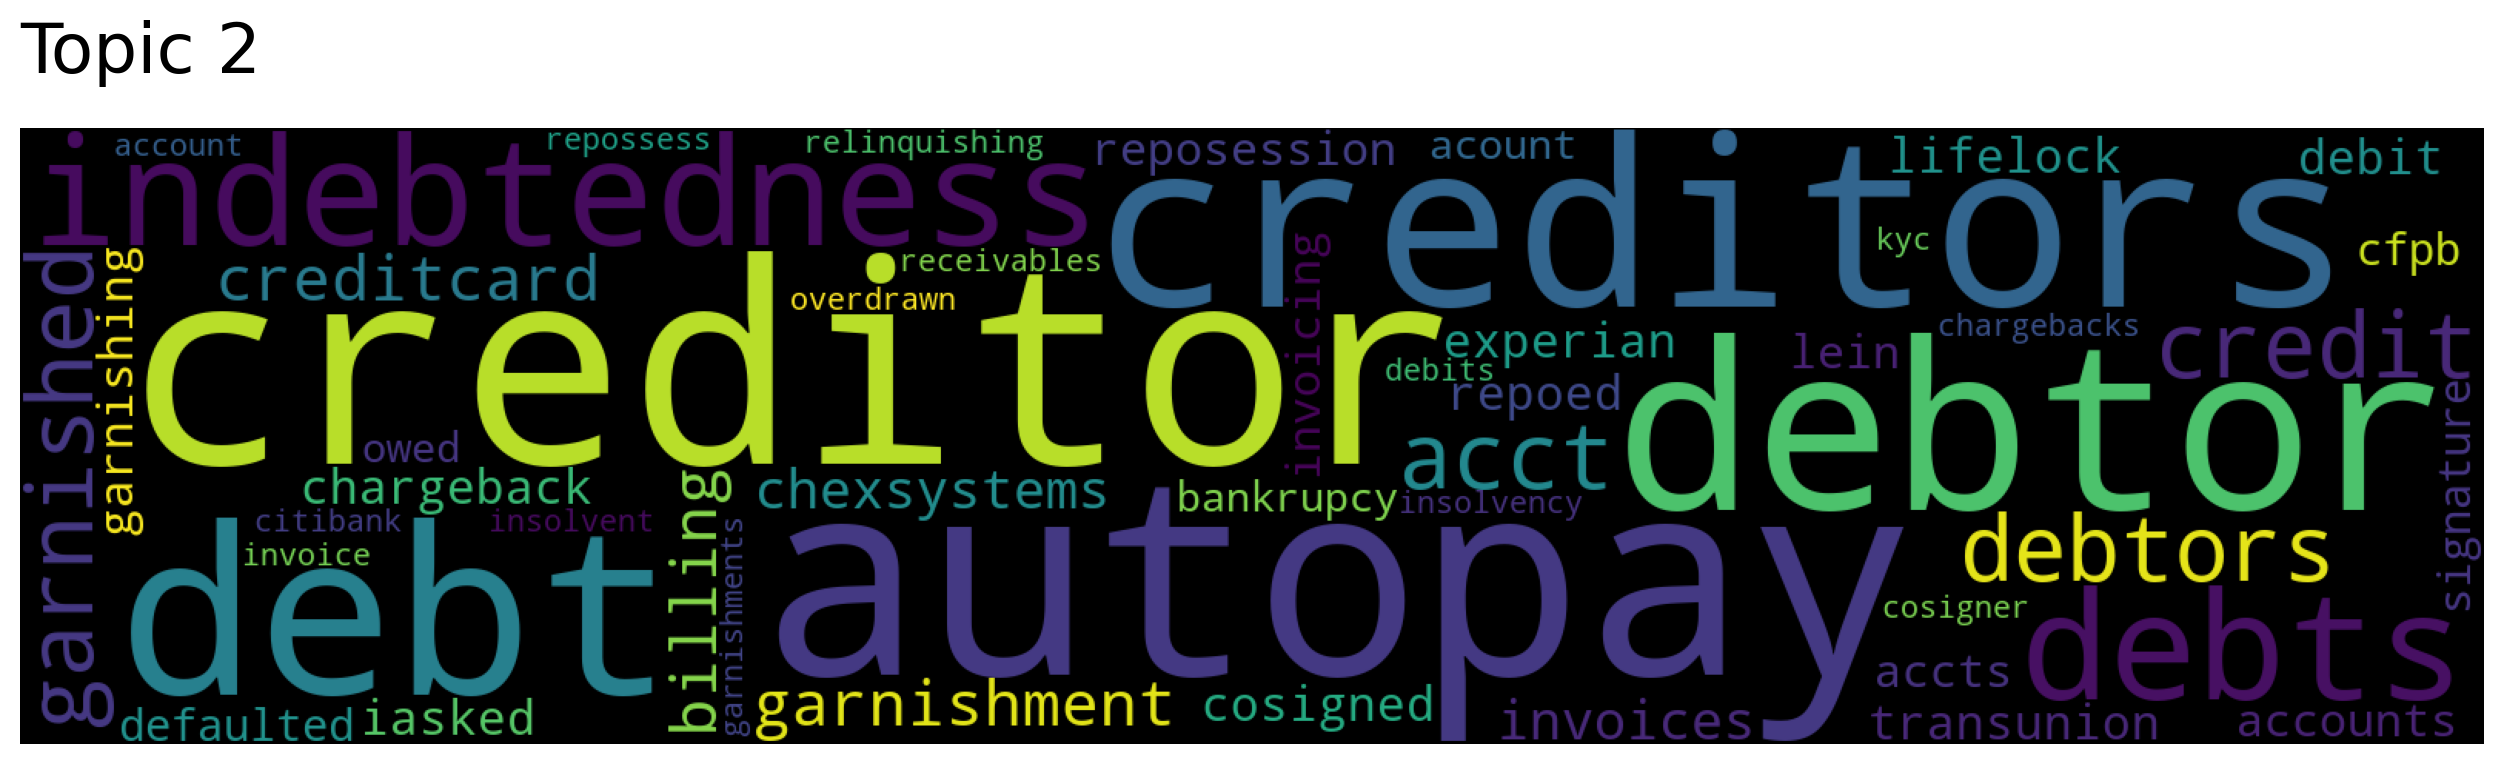

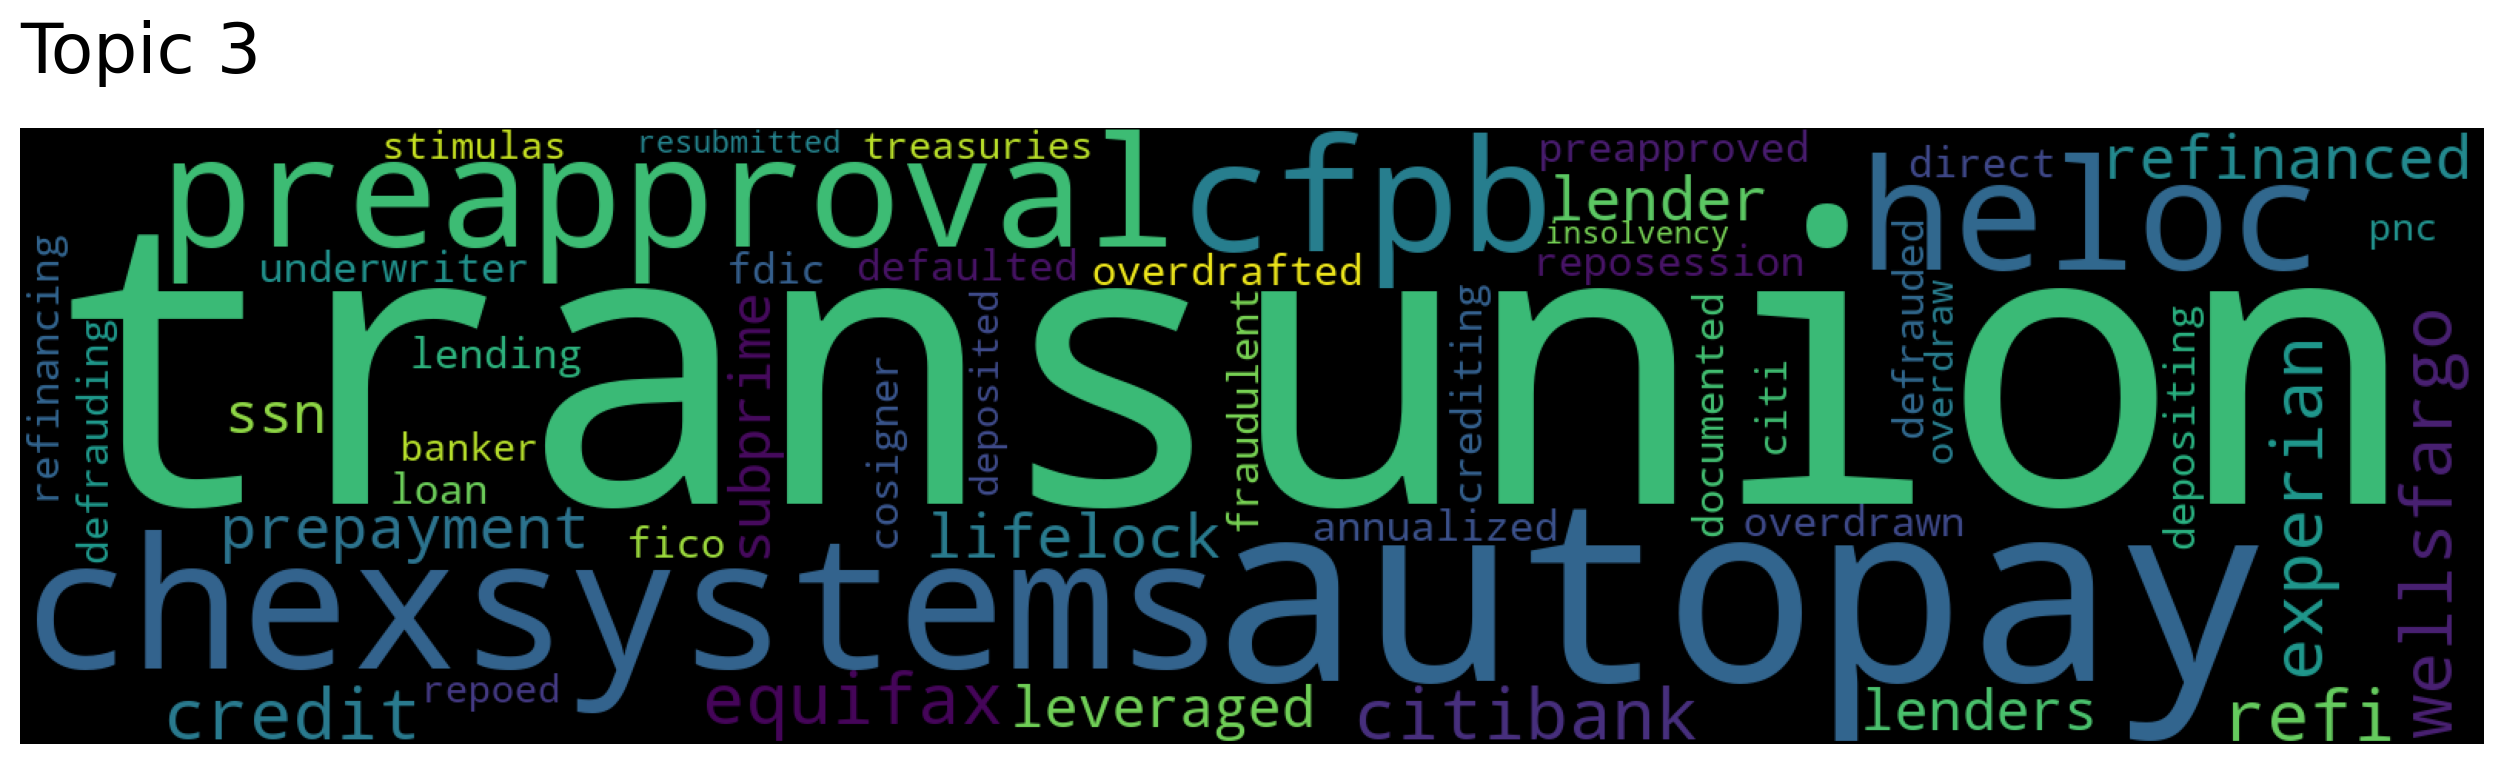

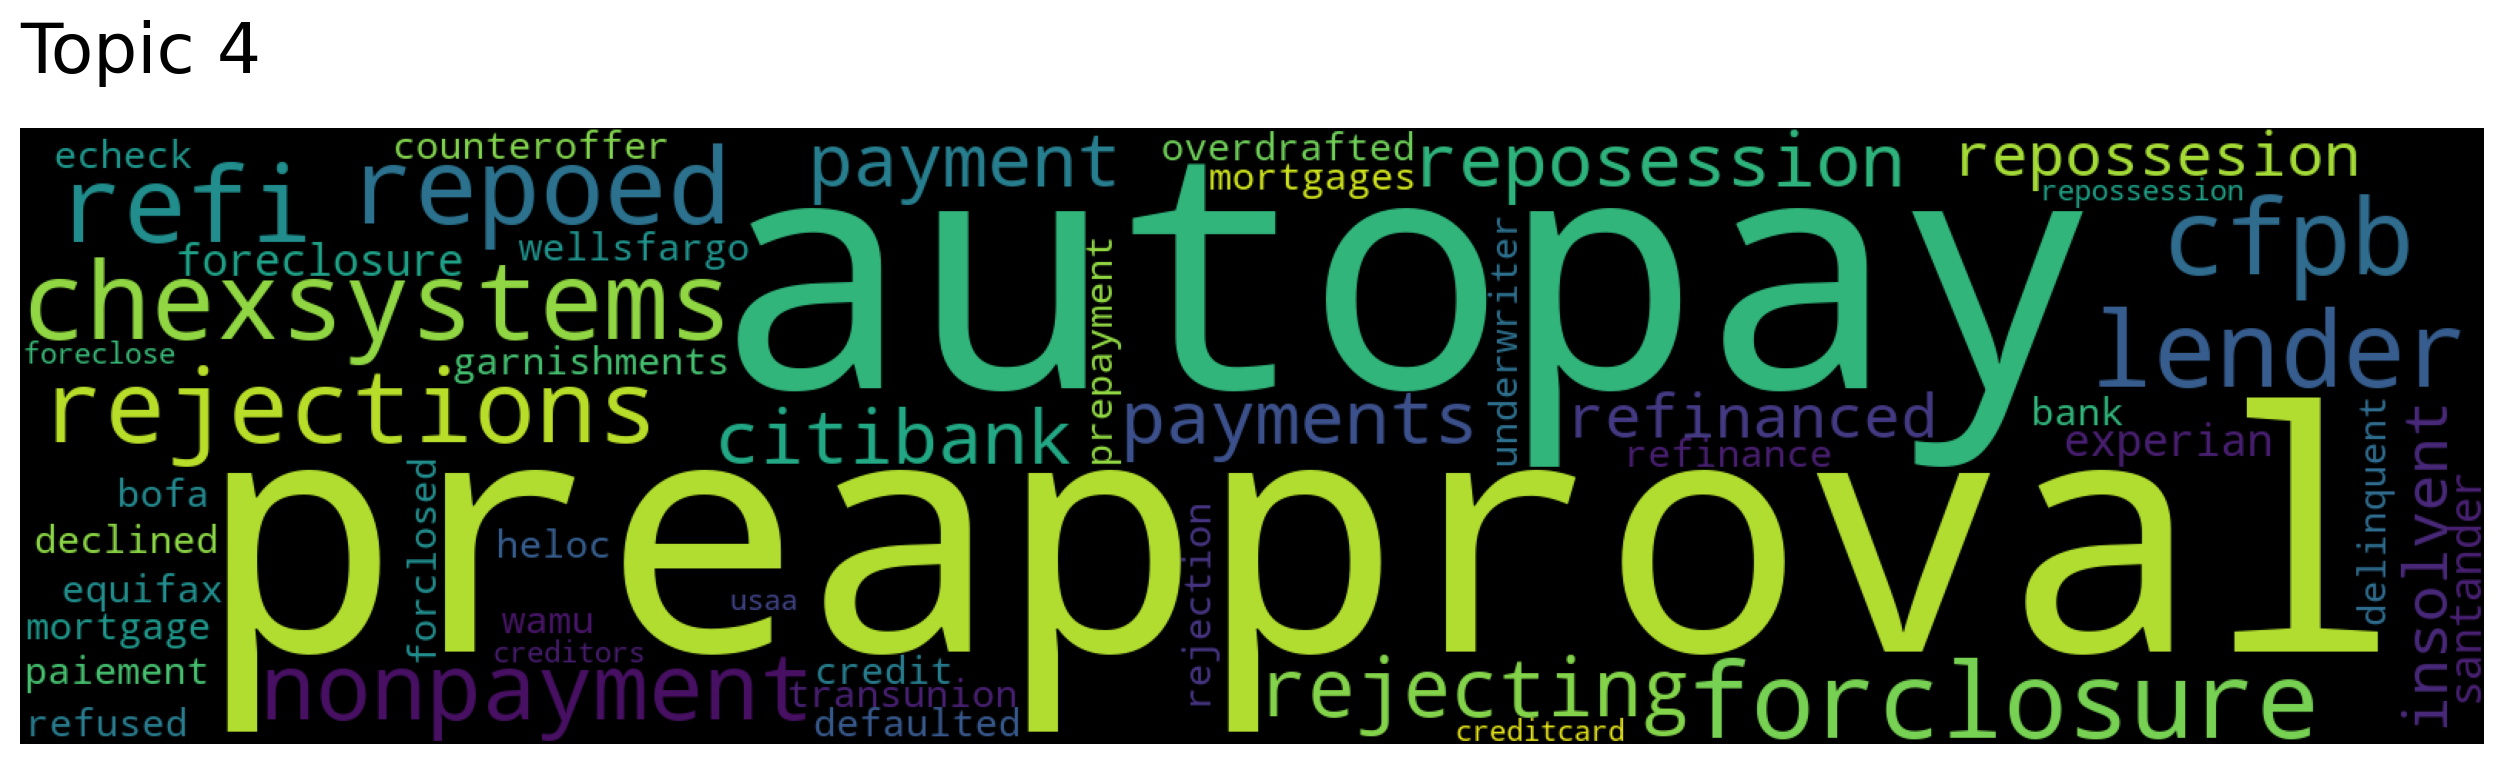

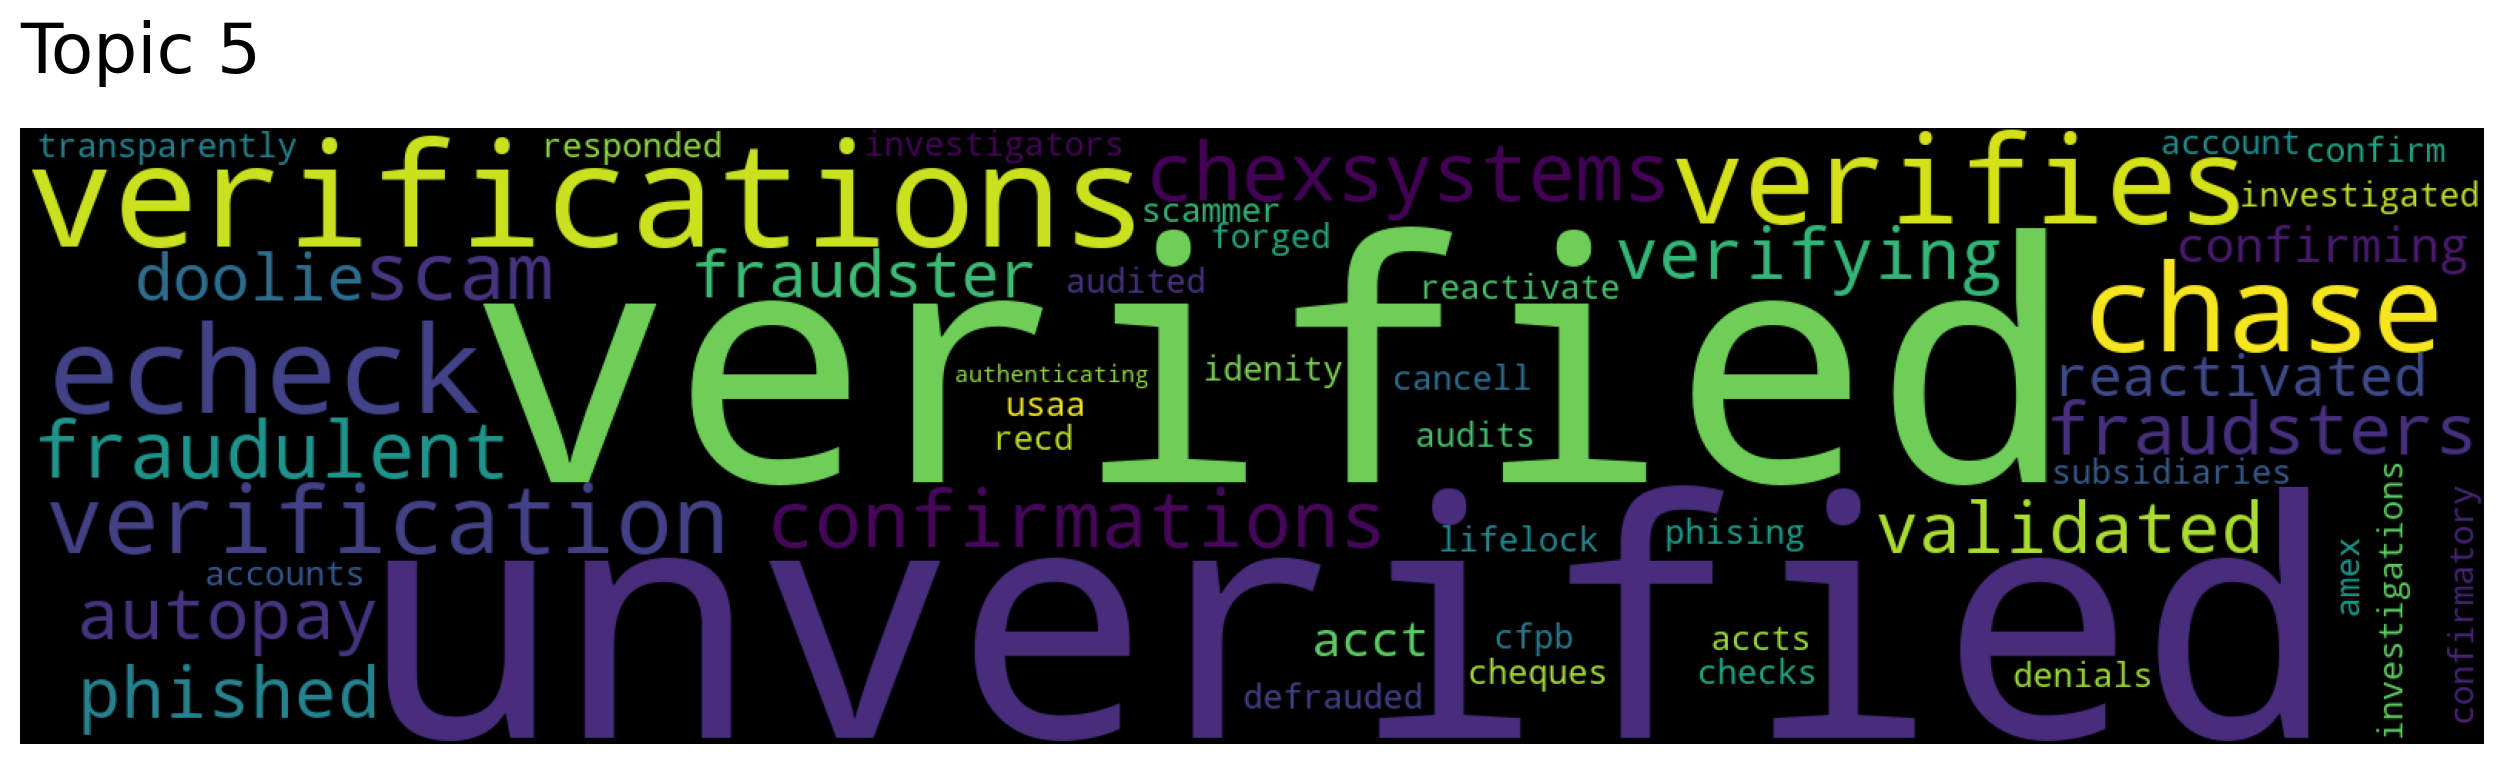

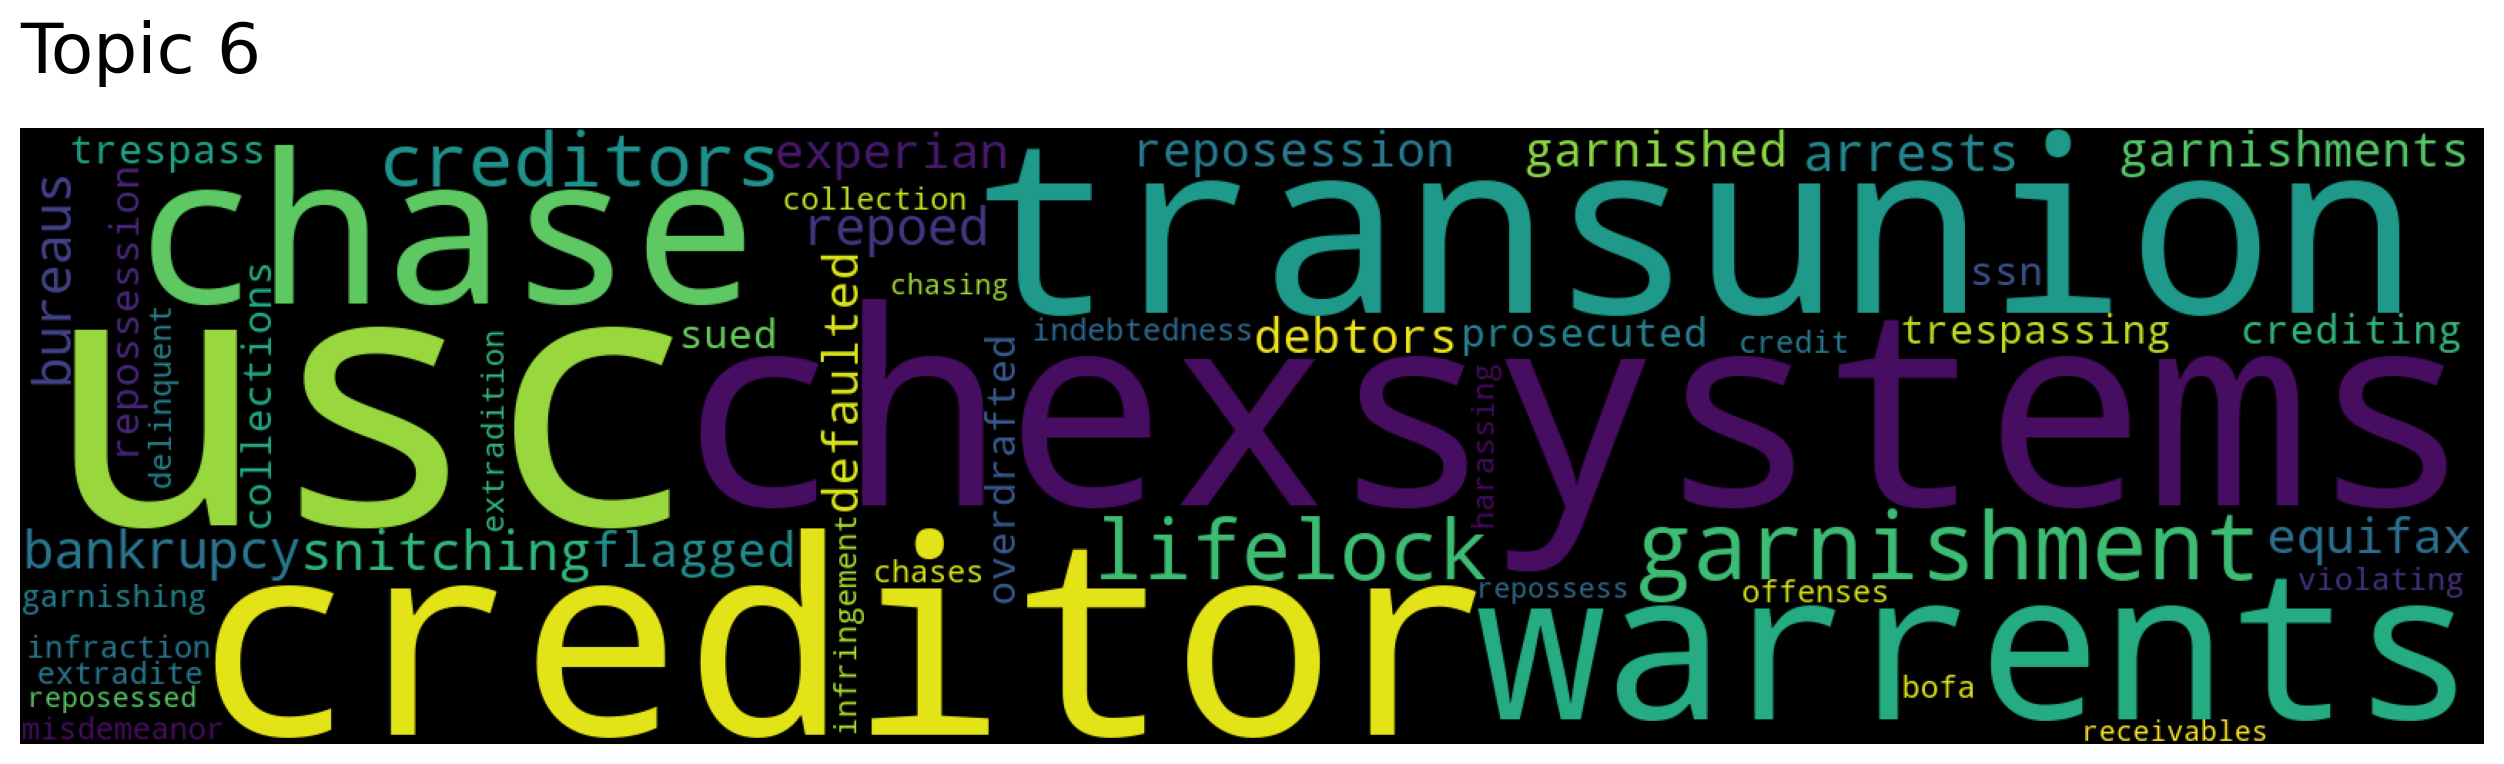

In [28]:
topic_words, word_scores, topic_nums = top2vec.get_topics(7)
for topic in topic_nums:
    top2vec.generate_topic_wordcloud(topic, background_color="black")

In [29]:
top2vec.save(os.path.join(os.getcwd(),'topic_models','final_t2v'))

## BERTopic

In [30]:
docs = list(removed_mask)

bertopic_base = BERTopic()
topics, ini_probs = bertopic_base.fit_transform(docs)

In [31]:
num_topics = len(bertopic_base.get_topics()) - 1
num_topics

153

In [32]:
bertopic_base.get_topic_info().head(10).set_index('Topic')[['Count', 'Name', 'Representation']]

Count                               Name  \
Topic                                             
-1      9547                   -1_to_and_the_my   
 0      1432         0_check_account_bank_funds   
 1       943  1_dispute_merchant_charge_charges   
 2       713          2_overdraft_fees_fee_3400   
 3       410         3_points_offer_bonus_miles   
 4       384     4_closed_credit_accounts_cards   
 5       334    5_inquiry_inquiries_hard_credit   
 6       294     6_amazon_card_amazoncom_credit   
 7       292               7_atm_debit_pin_card   
 8       219            8_jp_morgan_mortgage_of   

                                          Representation  
Topic                                                     
-1      [to, and, the, my, was, chase, of, that, in, me]  
 0     [check, account, bank, funds, checks, deposit,...  
 1     [dispute, merchant, charge, charges, the, card...  
 2     [overdraft, fees, fee, 3400, charged, insuffic...  
 3     [points, offer, bonus, miles, rewards, card, p...  
 4     [closed, credit, accounts, cards, card, close,...  
 5     [inquiry, inquiries, hard, credit, report, rem...  
 6     [amazon, card, amazoncom, credit, visa, prime,...  
 7     [atm, debit, pin, card, claim, transactions, f...  
 8     [jp, morgan, mortgage, of, jpmorgan, loan, for...

In [33]:
bertopic_base.visualize_barchart(top_n_topics = 16, n_words = 10)

### Fine Tuning

In [34]:
umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  metric='cosine'
                  )

hdbscan_model = HDBSCAN(min_cluster_size=15, 
                        metric='euclidean', 
                        cluster_selection_method='eom', 
                        prediction_data=True, 
                        min_samples=5)

bertopic_tune = BERTopic(
    top_n_words=10,
    n_gram_range=(1,2),
    min_topic_size=100,
    nr_topics="auto",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model
    )
topics, ini_probs = bertopic_tune.fit_transform(docs)

In [35]:
num_topics = len(bertopic_tune.get_topics()) - 1
num_topics

62

In [36]:
bertopic_tune.get_topic_info().head(10).set_index('Topic')[['Count', 'Name', 'Representation']]

Count                                    Name  \
Topic                                                  
-1     10960                        -1_the_to_and_my   
 0      5542                         0_the_to_and_my   
 1       695            1_fees_overdraft_account_fee   
 2       349        2_modification_loan_mortgage_the   
 3       287                3_amazon_card_credit_the   
 4       180    4_inquiries_credit_inquiry_my credit   
 5       175              5_bonus_coupon_account_the   
 6       171                    6_the_to_and_dispute   
 7       164                   7_of_the_jp_jp morgan   
 8       158  8_escrow_taxes_escrow account_mortgage   

                                          Representation  
Topic                                                     
-1      [the, to, and, my, that, was, chase, of, in, on]  
 0     [the, to, and, my, chase, that, was, on, credi...  
 1     [fees, overdraft, account, fee, the, to, my, m...  
 2     [modification, loan, mortgage, the, to, and, m...  
 3     [amazon, card, credit, the, to, and, chase, my...  
 4     [inquiries, credit, inquiry, my credit, report...  
 5     [bonus, coupon, account, the, deposit, direct,...  
 6     [the, to, and, dispute, item, that, return, wa...  
 7     [of, the, jp, jp morgan, morgan, and, in, morg...  
 8     [escrow, taxes, escrow account, mortgage, paym...

In [37]:
bertopic_tune.visualize_barchart(top_n_topics = 16, n_words = 10)

In [40]:
bertopic_tune.visualize_topics()

In [39]:
bertopic_tune.save(os.path.join(os.getcwd(),'topic_models','final_bertopic'), save_ctfidf=True, serialization="safetensors")

## Extra

In [ ]:
# # Instantiate the vectorizer model
# vectorizer_model = CountVectorizer()

# # Instantiate the UMAP model
# umap_model = UMAP(n_neighbors=15, n_components=5, metric='cosine')

# vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=list(set(stopwords.words('english')))) #bigram, remove stopwords
# docs = list(removed_mask)

# bertopic = BERTopic(
#     vectorizer_model=vectorizer_model,
#     language='english', 
#     calculate_probabilities=False,
#     verbose=True,
#     umap_model=umap_model)
# topics, probs = bertopic.fit_transform(docs)



In [ ]:
# vectorizer_model

In [ ]:
# freq = bertopic.get_topic_info()
# freq

# bertopic.update_topics(docs, vectorizer_model=vectorizer_model) 

In [ ]:
# freq = bertopic.get_topic_info()
# freq

In [ ]:
# from hdbscan import HDBSCAN

# model = BERTopic(nr_topics= 'auto',   
#     vectorizer_model=vectorizer_model,
#     language='english', 
#     calculate_probabilities=False,
#     verbose=True,
#     umap_model=umap_model)

# hdbscan_model = HDBSCAN(min_cluster_size=10, 
#                         metric='euclidean', 
#                         cluster_selection_method='eom', 
#                         prediction_data=True, 
#                         min_samples=5)
# topic_model = BERTopic(hdbscan_model=hdbscan_model, 
#                        nr_topics= 'auto')
# topics, probs = topic_model.fit_transform(docs)

In [ ]:
# # Further reduce topics
# freq = topic_model.get_topic_info()
# freq

In [ ]:
# topic_model.update_topics(docs, vectorizer_model=vectorizer_model) 
# freq = topic_model.get_topic_info()

In [ ]:
# freq.head()